In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
data = np.load('./gmm.npy')

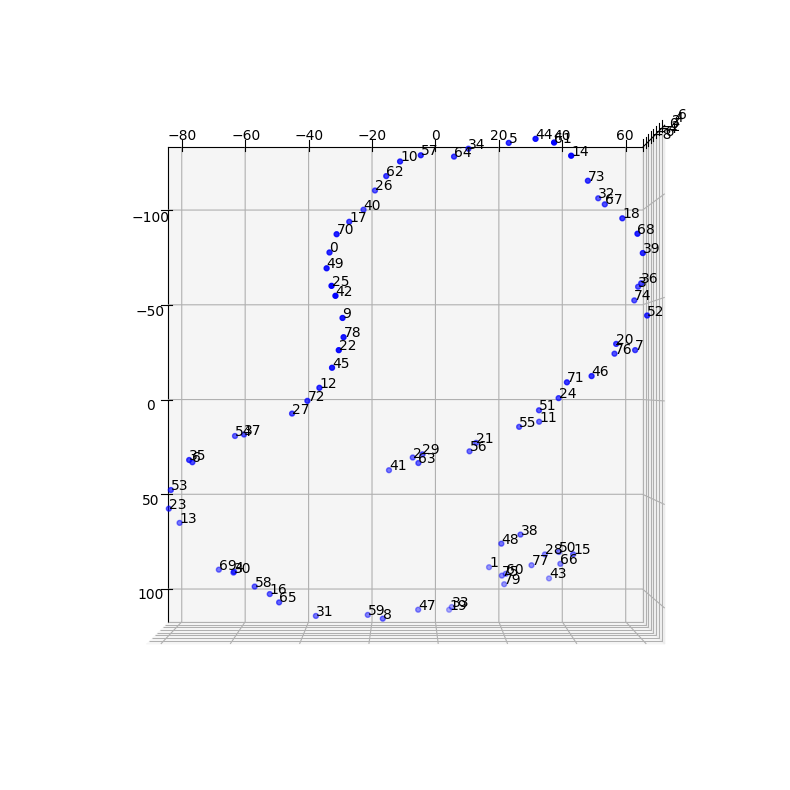

In [17]:
# plot 3d data, find the src and dst

std_data = data - data.mean(axis=0)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(90, 0)
ax.set_xlim(np.min(std_data[:, 0]), np.max(std_data[:, 0]))
ax.set_ylim(np.min(std_data[:, 1]), np.max(std_data[:, 1]))
ax.set_zlim(np.min(std_data[:, 2]), np.max(std_data[:, 2]))
ax.scatter(std_data[:, 0], std_data[:, 1], std_data[:, 2], s=50, c='b', marker='.')
for i in range(len(data)):
    ax.text(std_data[i, 0], std_data[i, 1], std_data[i, 2], str(i))
plt.show()

In [18]:
# create graph for data
def edge_weight_fn(x, y, sigma=1.0):
    dist = np.linalg.norm(x - y)
    weight = np.exp(-dist**2/(2*sigma**2))

    return weight

def create_graph(data, edge_weight_fn):
    n = len(data)
    graph = np.zeros((n, n))
    data = data - data.mean(axis=0)

    # compute the min distance between a point and its nearest neighbor
    # this is used to set sigma
    min_dists = []
    for i in range(n):
        min_dist = np.inf
        for j in range(n):
            if i != j:
                dist = np.linalg.norm(data[i] - data[j])
                if dist < min_dist:
                    min_dist = dist
        min_dists.append(min_dist)
    sigma = np.mean(np.array(min_dists))

    for i in range(n):
        for j in range(i+1, n):
            graph[i, j] = edge_weight_fn(data[i], data[j], sigma)
            graph[j, i] = graph[i, j]

    return graph

g = create_graph(data, edge_weight_fn)

Below is a numpy acceleration version of the above code.
The functionality is the same but the speed is much faster.

In [19]:
# create graph for data
def edge_weight_fn(distances, sigma=1.0):
    weights = np.exp(-distances**2/(2*sigma**2))
    return weights

def create_graph(data, edge_weight_fn):
    data = data - data.mean(axis=0)

    # compute the pairwise distance matrix using broadcasting
    sum_square = np.sum(data**2, axis=1)
    dist_matrix = np.sqrt(sum_square[:, None] + sum_square[None, :] - 2 * np.dot(data, data.T))

    # compute the min distance between a point and its nearest neighbor
    # this is used to set sigma
    min_dists = np.partition(dist_matrix, 1, axis=1)[:,1]
    sigma = np.mean(min_dists)

    # compute edge weights
    graph = edge_weight_fn(dist_matrix, sigma)
    np.fill_diagonal(graph, 0)

    return graph

g = create_graph(data, edge_weight_fn)

/tmp/ipykernel_16118/1897593382.py:11: RuntimeWarning: invalid value encountered in sqrt
  dist_matrix = np.sqrt(sum_square[:, None] + sum_square[None, :] - 2 * np.dot(data, data.T))


<Figure size 2000x2000 with 0 Axes>

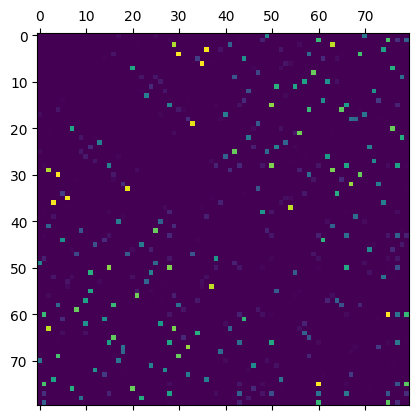

In [20]:
# plot adjacency matrix of g as image
plt.figure(figsize=(20, 20))
plt.matshow(g)

In [21]:
def graph_diffuse(g, data, steps=10, src=24, dst=40):
    heat_distribution = np.zeros(g.shape[0])
    heat_distribution[src] = 1
    degree_matrix = np.diag(np.sum(g, axis=1))
    adj_matrix = g
    normalized_adj_matrix = np.linalg.inv(degree_matrix) @ adj_matrix
            
    for i in range(steps):
        heat_distribution = normalized_adj_matrix @ heat_distribution
        heat_distribution[src] = 1
        heat_distribution[dst] = 0
    
    rank = np.argsort(heat_distribution)
    idx_to_rank = np.zeros(len(rank), dtype=np.int32)
    for i in range(len(rank)):
        idx_to_rank[rank[i]] = i
    lims = [np.min(data), np.max(data)]
    std_data = data - data.mean(axis=0)
    fig = plt.figure(figsize=(20, 20))
    # observation from above
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(90, 0)
    ax.set_xlim(*lims)
    ax.set_ylim(*lims)
    ax.set_zlim(*lims)
    # rank the data points according to heat distribution
    print(rank[dst], rank[src])
    ax.scatter(std_data[:, 0], std_data[:, 1], std_data[:, 2], s=50, c=heat_distribution, marker='o')
    for i in range(len(data)):
        ax.text(std_data[i, 0], std_data[i, 1], std_data[i, 2], f"{idx_to_rank[i]} ({heat_distribution[i]:.2f})")
    # color data points according to heat distribution(laels)
    plt.show()

42 2


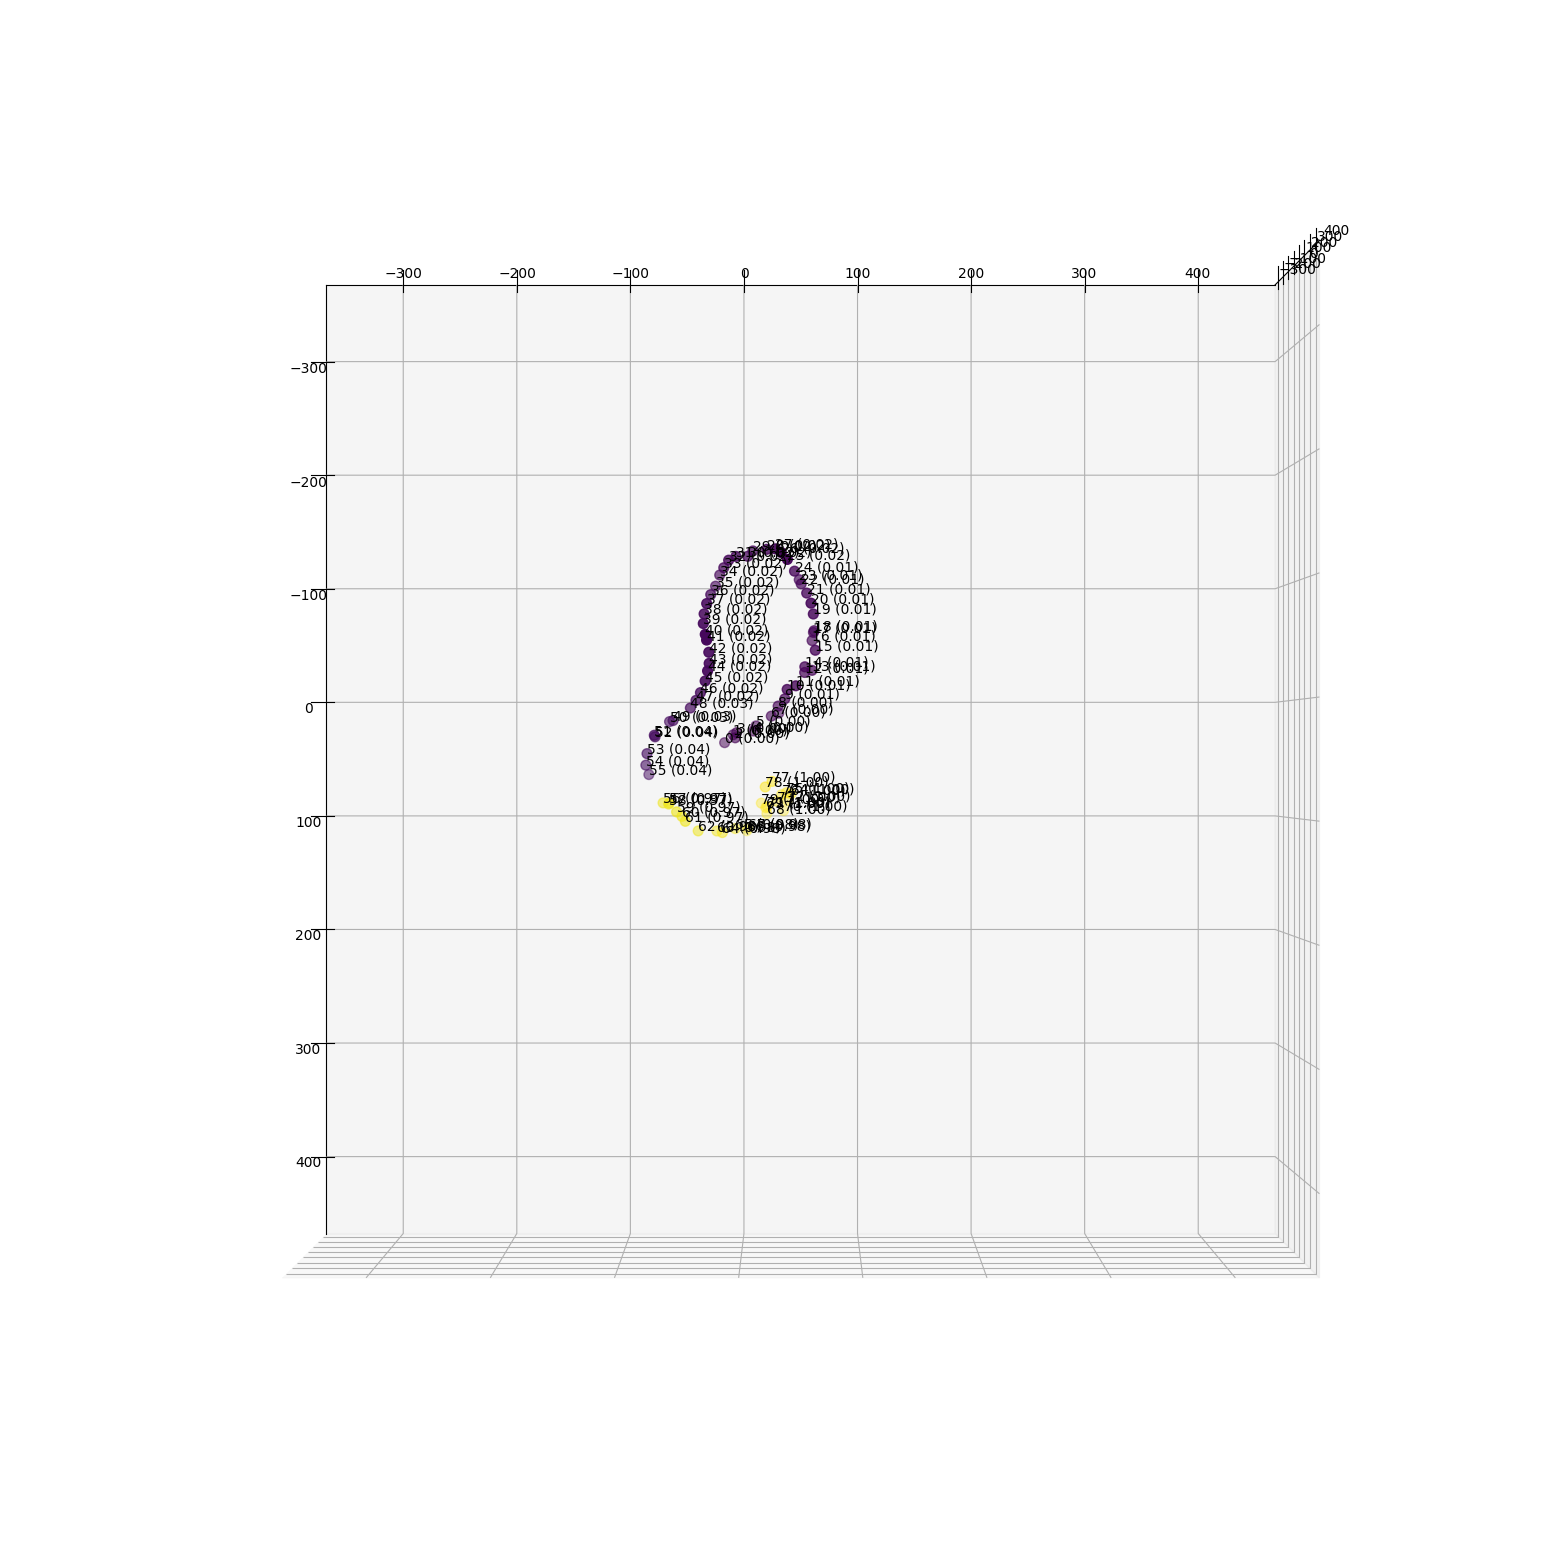

In [22]:
graph_diffuse(g, data, steps=9999, src=1, dst=41)